# Using ALBERT for Question Answering - SQuAD

Updates:

Things implemented:
- Data Loading
- Model
- Learner
- Prediction on new data
- Optimizer selection
- Segment IDs
- F1 Score
- Checkpoints
- Use a more powerful machine to train

TODO:
- Consider using the sliding window approach for long sequences


In [1]:
from src import *
from transformers import AutoTokenizer, AlbertForQuestionAnswering
from pathlib import Path
import numpy as np
import pandas as pd
import json
import pickle
import re
import collections
from tqdm import tqdm, trange
from datetime import datetime
import logging

In [2]:
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [3]:
config = Config(
    data_path = Path("../data/SQuAD/1.1"), # replace with the directory containing the parsed csv files
    output_dir = Path("./checkpoints"), # for storing model weights between epochs
    task = "SQuAD",
    testing=False,
    seed = 2020,
    model = 'albert-base-v2',
    max_lr=5e-5,
    optimizer="lamb", # choose between 'adam' or 'lamb'
    epochs=2,
    use_fp16=False,
    recreate_ds=False,
    bs=16, 
    effective_bs=16, # set this different from bs to determine gradient accumulation steps (i.e. effective_bs/bs)
    max_seq_len=512,
    start_tok = "[CLS]",
    end_tok = "[SEP]",
    sep_tok = "[SEP]",
    unk_tok_idx=1,
    sep_idx=3,
    pad_idx=0,
    feat_cols = ["paragraph","question"],
    label_cols = "idxs",
    adjustment = 1,
    save_checkpoint = True,
    load_checkpoint=None#"albert-base-v2-accuracy-0.72-epoch-0-2020-01-24 18:54:15.308899"
)

config.model_name = re.findall(r"(.+?)-",config.model)[0]

# set optimizer
assert config.optimizer.lower() in ["adam","lamb"], f"invalid optimizer in config {config.optimizer}"
config.opt_func = lamb_opt() if config.optimizer.lower() == "lamb" else adam_opt()

In [45]:
# utility functions
def remove_max_sl(df):
    init_len = len(df)
    df = df[df.seq_len < config.max_seq_len-2]
    new_len = len(df)
    print(f"dropping {init_len - new_len} out of {init_len} questions")
    return df

def str2tensor(s):
    indices = re.findall("\d+",s)
    return torch.tensor([int(indices[0]), int(indices[1])], dtype=torch.long)

# Loading the data

In [5]:
train = pd.read_csv(config.data_path/f"train_{config.model_name}.csv")
valid = pd.read_csv(config.data_path/f"val_{config.model_name}.csv")

In [6]:
# randomizing the order of training data
train = train.sample(frac=1,random_state = config.seed).reset_index(drop=True)
valid = valid.sample(frac=1, random_state = config.seed).reset_index(drop=True)

In [7]:
# reduce df sizes if testing
if config.testing:
    train = train[:1000]
    valid = valid[:500]

In [8]:
train, valid = remove_max_sl(train), remove_max_sl(valid)

dropping 136 out of 87599 questions
dropping 184 out of 34726 questions


In [9]:
train.head()

,question,paragraph,answer,idxs,seq_len
0,About how many million square feet of office s...,Many of the world's largest media conglomerate...,['▁400'],"[57, 58]",99
1,On what date was George York executed?,The last use of the firing squad between 1608 ...,"['▁june', '▁22', ',', '▁1965']","[59, 63]",147
2,How did Wallace claim that patterns in the dis...,"An 1855 paper on the ""introduction"" of species...","['▁if', '▁every', '▁new', '▁species', '▁always...","[34, 50]",237
3,How did Gaddafi's decisions in the oil industr...,With crude oil as the country's primary export...,"['▁in', '▁1970', ',', '▁other', '▁op', 'ec', '...","[65, 87]",149
4,What word describes an aortic valve with two r...,Schwarzenegger was born with a bicuspid aortic...,"['▁b', 'icus', 'pid']","[7, 10]",132


# Setting up the Tokenizer

In [10]:
class TokenizerProcessor(Processor):
    def __init__(self, tok_func, max_sl, start_tok, end_tok, pre_rules=None,post_rules=None):
        self.tok_func,self.max_sl = tok_func,max_sl
        self.pre_rules,self.post_rules=pre_rules,post_rules
        self.start_tok, self.end_tok = start_tok, end_tok

    def proc1(self, x): return [self.start_tok] + self.tok_func(x)[:self.max_sl-2] + [self.end_tok]
    
    def __call__(self, items): return tqdm([self.proc1(x) for x in items])

class NumericalizeProcessor(Processor):
    """
    only works with an existing vocab at the moment and min_freq is not accounted for
    """
    def __init__(self, vocab:dict, unk_tok_idx:int, min_freq=2): 
        self.vocab, self.unk_tok_idx, self.min_freq = vocab, unk_tok_idx, min_freq
    
    def proc1(self, x): return [self.vocab[i] if i in self.vocab else self.unk_tok_idx for i in x]
    
    def __call__(self, items): 
        if getattr(self, 'otoi', None) is None:
            self.otoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.vocab)})
        return tqdm([self.proc1(x) for x in items])

In [11]:
tok = AutoTokenizer.from_pretrained(config.model)
proc_tok = TokenizerProcessor(tok.tokenize, config.max_seq_len, config.start_tok, config.end_tok)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/albert-base-v2-spiece.model HTTP/1.1" 200 0
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/albert-base-v2-spiece.model from cache at /home/ubuntu/.cache/torch/transformers/dd1588b85b6fdce1320e224d29ad062e97588e17326b9d05a0b29ee84b8f5f93.c81d4deb77aec08ce575b7a39a989a79dd54f321bfb82c2b54dd35f52f8182cf


In [12]:
vocab = {tok.convert_ids_to_tokens(i):i for i in range(tok.vocab_size)}
proc_num = NumericalizeProcessor(vocab, unk_tok_idx=config.unk_tok_idx)

In [13]:
class QALabelProcessor(Processor):
    def __init__(self, parse_func = noop, adjustment = 1):
        self.parse_func = parse_func
        self.adjustment = adjustment
    def proc1(self, item): return self.parse_func(item) + self.adjustment
    def __call__(self, items): return [self.proc1(item) for item in items]
    

In [14]:
proc_qa = QALabelProcessor(str2tensor)

In [15]:
class TextList(ItemList):      
    @classmethod  
    def from_df(cls, df, feat_cols, label_col, sep_tok, test=False):
        feat_cols = listify(feat_cols)
        x = df[feat_cols[0]]
        for i in range(1,len(feat_cols)):
            x += f" {sep_tok} " + df[feat_cols[i]]
        labels = cls(df[label_col]) if not test else cls([0 for _ in len(df)])
        return cls(x,labels=labels)

In [16]:
if (not (config.data_path/"squad_data_trn.pkl").exists()) or config.recreate_ds or config.testing:
    il_train = TextList.from_df(train,config.feat_cols,config.label_cols,config.sep_tok)
    il_valid = TextList.from_df(valid,config.feat_cols,config.label_cols,config.sep_tok)

    ll_valid = LabeledData(il_valid,il_valid.labels,proc_x = [proc_tok,proc_num], proc_y=[proc_qa])
    ll_train = LabeledData(il_train,il_train.labels,proc_x = [proc_tok,proc_num], proc_y=[proc_qa])

    # saving/loading presaved data
    if not config.testing:
        # save an object
        pickle.dump(ll_train, open( config.data_path/"squad_data_trn.pkl", "wb" ) )
        pickle.dump(ll_valid, open( config.data_path/"squad_data_val.pkl", "wb" ) )
else:
    # load an object
    ll_train = pickle.load( open( config.data_path/"squad_data_trn.pkl", "rb" ) )
    ll_valid = pickle.load( open( config.data_path/"squad_data_val.pkl", "rb" ) )

In [17]:
from torch.utils.data import Sampler

class SortSampler(Sampler):
    def __init__(self, data_source, key): self.data_source,self.key = data_source,key
    def __len__(self): return len(self.data_source)
    def __iter__(self):
        return iter(sorted(list(range(len(self.data_source))), key=self.key, reverse=True))

In [18]:
class SortishSampler(Sampler):
    def __init__(self, data_source, key, bs):
        self.data_source,self.key,self.bs = data_source,key,bs

    def __len__(self) -> int: return len(self.data_source)

    def __iter__(self):
        idxs = torch.randperm(len(self.data_source))
        megabatches = [idxs[i:i+self.bs*50] for i in range(0, len(idxs), self.bs*50)]
        sorted_idx = torch.cat([tensor(sorted(s, key=self.key, reverse=True)) for s in megabatches])
        batches = [sorted_idx[i:i+self.bs] for i in range(0, len(sorted_idx), self.bs)]
        max_idx = torch.argmax(tensor([self.key(ck[0]) for ck in batches]))  # find the chunk with the largest key,
        batches[0],batches[max_idx] = batches[max_idx],batches[0]            # then make sure it goes first.
        batch_idxs = torch.randperm(len(batches)-2)
        sorted_idx = torch.cat([batches[i+1] for i in batch_idxs]) if len(batches) > 1 else LongTensor([])
        sorted_idx = torch.cat([batches[0], sorted_idx, batches[-1]])
        return iter(sorted_idx)

In [19]:
def pad_collate_qa(samples, pad_idx=config.pad_idx, pad_first=False):
    max_len = max([len(s[0]) for s in samples])
    res = torch.zeros(len(samples), max_len).long() + pad_idx
    for i,s in enumerate(samples):
        if pad_first: res[i, -len(s[0]):] = torch.LongTensor(s[0])
        else:         res[i, :len(s[0]) ] = torch.LongTensor(s[0])
    return res, torch.cat([s[1].unsqueeze(0) for s in samples])

In [20]:
train_sampler = SortishSampler(ll_train.x, key=lambda t: len(ll_train[int(t)][0]), bs=config.bs)
train_dl = DataLoader(ll_train, batch_size=config.bs, sampler=train_sampler, collate_fn=pad_collate_qa)

valid_sampler = SortSampler(ll_valid.x, key=lambda t: len(ll_valid[int(t)][0]))
valid_dl = DataLoader(ll_valid, batch_size=config.bs, sampler=valid_sampler, collate_fn=pad_collate_qa)

# Setting up the Databunch

In [22]:
data = DataBunch(train_dl,valid_dl)

# Training Model

In [23]:
config.sep_idx = 3

In [24]:
def set_segments(x,sep_idx=config.sep_idx):
    res = x.new_zeros(x.size())
    for row_idx, row in enumerate(x):
        in_seg_1 = False
        for val_idx,val in enumerate(row):
            if val == sep_idx:
                in_seg_1 = True
            if in_seg_1: 
                res[row_idx,val_idx] = 1
    return res

In [25]:
weights = config.output_dir/config.load_checkpoint if config.load_checkpoint else config.model

class CustomAlbertModel(nn.Module):
    def __init__(self):
        super(CustomAlbertModel,self).__init__()
        self.bert = AlbertForQuestionAnswering.from_pretrained(weights)
        self.bert.train()
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):       
        token_type_ids = set_segments(input_ids)
        outputs = self.bert(input_ids,token_type_ids=token_type_ids)
        return outputs

In [26]:
def save_model(learner,output_dir: Path):
    def _create_dir(dirc):
        if not os.path.exists(dirc): os.mkdir(dirc)
    epoch = learner.epoch
    metric = round(float(learner.qa_avg_stats.valid_stats.avg_stats[1]),2)
    _create_dir(output_dir)
    model_dir = f"{config.model}-accuracy-{metric}-epoch-{epoch}-" + str(datetime.now())
    _create_dir(output_dir/model_dir)
    learner.model.bert.save_pretrained(output_dir/model_dir)

class SaveModelCallback(Callback):
    def __init__(self,save_model_func,output_dir):
        self.output_dir, self.save_model_func = output_dir,save_model_func
    def after_epoch(self):
        self.save_model_func(self, self.output_dir)        

In [27]:
# gradient accumulation
class GradientAccumulation(Callback):
    def __init__(self,bs,effective_bs):
        self.bs, self.effective_bs = bs, effective_bs
    def after_backward(self):
        if self.n_iter*self.bs % self.effective_bs != 0: raise CancelBatchException()

In [28]:
# defining the loss function
def cross_entropy_qa(input, target):
    """
    Summing the cross entropy loss from the starting and ending indices. 
    """
    loss = torch.add(F.cross_entropy(input[0], target[:,0]) , F.cross_entropy(input[1], target[:,1]))
    return loss

In [29]:
class QAAvgStats(AvgStats):
    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb, run.xb) * bn
            
class QAAvgStatsCallback(AvgStatsCallback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = QAAvgStats(metrics,True),QAAvgStats(metrics,False)

In [30]:
# defining the evaluation metrics based on squad evaluation method
def acc_qa(input,target,xb):
    """
    Taking the average between the accuracies of predicting the start and ending indices
    """
    return (accuracy(input[0], target[:,0]) + accuracy(input[1], target[:,1]))/2

def exact_match(input,target,xb):
    def _acc(out, yb): return (torch.argmax(out, dim=1)==yb).float()
    return (_acc(input[0], target[:,0]) + _acc(input[1], target[:,1]) == 2).float().mean()

In [31]:
def f1_score(input,target,xb):
    """
    based on the official evaluation script:
    https://worksheets.codalab.org/rest/bundles/0x6b567e1cf2e041ec80d7098f031c5c9e/contents/blob/
    """
    pred_starts,pred_ends = [torch.argmax(out, dim=1) for out in input]
    gold_starts,gold_ends = target[:,0], target[:,1]
    
    def _get_toks(idx,start,end):
        if start == end: end += 1
        return xb[idx][start:end]
    
    def _score1(pred_toks,gold_toks):
        common = collections.Counter(gold_toks.tolist()) & collections.Counter(pred_toks.tolist())
        num_same = sum(common.values())
        if num_same == 0: 
            return 0
        precision = 1.0 * num_same / len(pred_toks)
        recall = 1.0 * num_same / len(gold_toks)
        f1 = (2 * precision * recall) / (precision + recall)
        return f1
    
    pred_toks = [_get_toks(i,start,end) for i,(start,end) in enumerate(zip(pred_starts,pred_ends))]
    gold_toks = [_get_toks(i,start,end) for i,(start,end) in enumerate(zip(gold_starts,gold_ends))]
    score = np.mean([_score1(pred,gold) for pred,gold in zip(pred_toks,gold_toks)])
    return score             

In [32]:
cbfs = [partial(QAAvgStatsCallback,[acc_qa,exact_match,f1_score]),
        CudaCallback,
        ProgressCallback,
        Recorder]

if not config.testing and config.save_checkpoint: 
    cbfs.append(partial(SaveModelCallback,save_model,config.output_dir))
    
if config.effective_bs and config.bs != config.effective_bs:
    cbfs.append(partial(GradientAccumulation,config.bs,config.effective_bs))

In [33]:
model = CustomAlbertModel()

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/albert-base-v2-config.json HTTP/1.1" 200 0
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/albert-base-v2-config.json from cache at /home/ubuntu/.cache/torch/transformers/0bbb1531ce82f042a813219ffeed7a1fa1f44cd8f78a652c47fc5311e0d40231.ea38adf566af403b92e06f53ac1b443ebd324162fc74a90de95609963d429505
INFO:transformers.configuration_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "finetuning_task": null,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABE

In [34]:
def albert_splitter(m, g1=[],g2=[]):
    if "qa_outputs" in list(dict(m.named_children()).keys()) :
        g2+= m.qa_outputs.parameters()
        pass
    elif isinstance(m,torch.nn.modules.normalization.LayerNorm):
        g2+= m.parameters()
    elif hasattr(m, 'weight'): 
        g1+= m.parameters()
    for ll in m.children(): albert_splitter(ll, g1, g2)
    return g1,g2



In [35]:
# https://github.com/fastai/course-v3/blob/master/nbs/dl2/11_train_imagenette.ipynb
def create_phases(phases):
    phases = listify(phases)
    return phases + [1-sum(phases)]

# https://github.com/fastai/course-v3/blob/master/nbs/dl2/11a_transfer_learning.ipynb
def sched_1cycle(lrs, pct_start=0.3, mom_start=0.95, mom_mid=0.85, mom_end=0.95):
    phases = create_phases(pct_start)
    sched_lr  = [combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
                 for lr in lrs]
    sched_mom = combine_scheds(phases, cos_1cycle_anneal(mom_start, mom_mid, mom_end))
    return [ParamScheduler('lr', sched_lr),
            ParamScheduler('mom', sched_mom)]

disc_lr_sched = sched_1cycle([config.max_lr,1e-4], 0.5) # 3e-2 best with adam, 1e-3 for lamb

In [36]:
# the learning rate we apply here does not matter since we are scheduling 
learn = Learner(model, data, cross_entropy_qa,lr=config.max_lr,cb_funcs=cbfs,splitter=albert_splitter,opt_func=config.opt_func)


[21, 8]

In [37]:
learn.fit(2,cbs=disc_lr_sched)

epoch,train_loss,train_acc_qa,train_exact_match,train_f1_score,valid_loss,valid_acc_qa,valid_exact_match,valid_f1_score,time
0,3.986166,0.494579,0.345008,0.538306,2.292416,0.693381,0.556142,0.773515,2:13:51
1,2.129145,0.693185,0.554693,0.769716,2.144678,0.711909,0.581786,0.792053,2:15:43


INFO:transformers.configuration_utils:Configuration saved in checkpoints/albert-base-v2-accuracy-0.69-epoch-0-2020-01-28 17:39:38.207929/config.json
INFO:transformers.modeling_utils:Model weights saved in checkpoints/albert-base-v2-accuracy-0.69-epoch-0-2020-01-28 17:39:38.207929/pytorch_model.bin
INFO:transformers.configuration_utils:Configuration saved in checkpoints/albert-base-v2-accuracy-0.71-epoch-1-2020-01-28 19:55:21.593928/config.json
INFO:transformers.modeling_utils:Model weights saved in checkpoints/albert-base-v2-accuracy-0.71-epoch-1-2020-01-28 19:55:21.593928/pytorch_model.bin


In [38]:
learn.fit(2,cbs=disc_lr_sched)

epoch,train_loss,train_acc_qa,train_exact_match,train_f1_score,valid_loss,valid_acc_qa,valid_exact_match,valid_f1_score,time
0,1.944356,0.713589,0.579266,0.791034,2.180622,0.713229,0.585571,0.792867,2:15:35
1,1.799865,0.731735,0.600259,0.809088,2.125806,0.719215,0.590969,0.800733,2:15:52


INFO:transformers.configuration_utils:Configuration saved in checkpoints/albert-base-v2-accuracy-0.71-epoch-0-2020-01-28 22:10:57.359426/config.json
INFO:transformers.modeling_utils:Model weights saved in checkpoints/albert-base-v2-accuracy-0.71-epoch-0-2020-01-28 22:10:57.359426/pytorch_model.bin
INFO:transformers.configuration_utils:Configuration saved in checkpoints/albert-base-v2-accuracy-0.72-epoch-1-2020-01-29 00:26:50.348875/config.json
INFO:transformers.modeling_utils:Model weights saved in checkpoints/albert-base-v2-accuracy-0.72-epoch-1-2020-01-29 00:26:50.348875/pytorch_model.bin


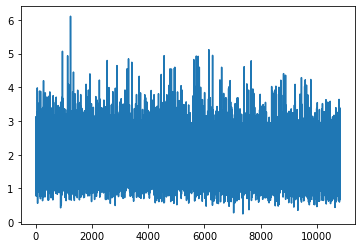

In [49]:
learn.recorder.plot_loss()

In [40]:
# manually save and load model weights

# save_model(learn,config.out_path)
# learn.model.bert.from_pretrained(config.output_dir/'albert-base-v2-accuracy-0.72-epoch-3-2020-01-24 16:22:37.693825')

# Predictions

In [41]:
def pad_collate_x(samples, pad_idx=config.pad_idx, pad_first=False):
    max_len = max([len(s[0]) for s in samples])
    res = torch.zeros(len(samples), max_len).long() + pad_idx
    for i,s in enumerate(samples):
        if pad_first: res[i, -len(s[0]):] = torch.LongTensor(s[0])
        else:         res[i, :len(s[0]) ] = torch.LongTensor(s[0])
    return res

def get_pred(text, model, tok):
    # 0. Ensure the input is a list for batch processing
    text = listify(text)
    # 1. tokenize/encode the input text
    input_ids = pad_collate_x([torch.tensor(tok.encode(t)).unsqueeze(0) for t in text])
    if torch.cuda.is_available(): input_ids, model = input_ids.cuda(), model.cuda()
    # 2. extract the logits vector for each item 
    logits = model(input_ids)
    # 3. apply argmax to the logits so we have the probabilities of each item's start and end indices
    starts,ends = [torch.argmax(out, dim=1) for out in logits]
    
    def _proc1(idx,start,end):
        # function to process one item at a time
        if start > end:
            return "unanswerable"
        elif start == end:
            end += 1
        pred = tok.convert_ids_to_tokens(input_ids[idx][start:end])
        return tok.convert_tokens_to_string(pred)
    return [_proc1(idx,start,end) for idx,(start,end) in enumerate(zip(starts,ends))]

In [42]:
# tests with samples 
sample1 = "[CLS] there have been thirty earthquakes in the past three days. [SEP] how many earthquakes have there been? [SEP]"
sample2 = "[CLS] the storm took place yesterday from dawn to dusk [SEP] what took place??"
sample3 = "[CLS] No.2 pencils are used a lot in schools. [SEP] what are used?"
get_pred([sample1,sample2,sample3], learn.model, tok)

['thirty', 'storm', 'no.2 pencils']